In [1]:
using LinearAlgebra
using Convex
using SCS
using PyPlot
using ForwardDiff
using LaTeXStrings

In [2]:
struct Quadratic
  minimum::Float64
  minimizer::Array{Float64}
  growth::Float64
end

function addWeightedQuadratics(eta1, quad1, eta2, quad2)
#Returns the quadratic eta1*quad1 + eta2*quad2
    w1 = quad1.growth*eta1/(quad1.growth*eta1+quad2.growth*eta2)
    w2 = quad2.growth*eta2/(quad1.growth*eta1+quad2.growth*eta2)
    new_minimizer = w1*quad1.minimizer+ w2*quad2.minimizer

    new_minimum = (eta1+eta2)*w1*quad1.minimum + (eta1+eta2)*w2*quad2.minimum + 0.5*(eta1*quad1.growth + eta2*quad2.growth)*w1*w2*norm(quad1.minimizer-quad2.minimizer,2)^2 
    
    new_growth = eta1*quad1.growth + eta2*quad2.growth
    
    return Quadratic(new_minimum, new_minimizer, new_growth)
end


function subgradientMethod(f, gradf, xtrue, mu, T, dim, lambda_list, beta)
#Given oracle functions (f, gradf), strong convexity mu, step bound T, and dimension dim
#    We run the subgradient method with alpha_k = k^p/mu(\sum i^p+beta)
#    which is equivalent to dual averaging with \lambda_k=k^p and \beta_k=beta
#Returns three lists of the primal and dual objective values and averaged iterate primal gap.
#    Our theory shows these should be M^2/mu*T from the true optimal objective value

    #We initialize at the origin for ease (start counting from i from 1 to avoid division by zero)    
    x1 = zeros(dim)
    basicQuadratic = Quadratic(0.0,x1,1)
    xi = x1
    x_average = x1    #equals \sum_i sigma_i x_i
    f_average = f(x1) #equals \sum_i sigma_i f(x_i)
    modeli = Quadratic(f(x1)-norm(gradf(x1),2)^2/(2*mu), x1 - gradf(x1)/mu, mu) #equals \sum_i theta_i quadratic_i
 
    sum_of_lambda_i = lambda_list[1]

    #We will record primal and dual values based on the weightings below
    #Primal: sigma_k = lambda_list[k]/sum_{i=1}^{k}lambda_list[i] 
    #Dual:   theta_k = lambda_list[k]/sum_{i=1}^{k}lambda_list[i]
    primal_values   = zeros(T)
    dual_values     = zeros(T)
    average_iterate_primal_values = zeros(T)
    f_list = zeros(T)
    distance_values = zeros(T)    
    gradient_list = zeros(n,T)
    for i in 1:T
        #Record current primal gap, dual gap, and obj at average primal iterate
        primal_values[i] = f_average
        dual_values[i]   = modeli.minimum
        average_iterate_primal_values[i] = f(x_average)
        f_list[i] = f(xi)
        gradient_list[:,i] = gradf(xi)
        distance_values[i] = norm(xi-xtrue,2)^2

        #Compute penalized quadratic and update to next iterate
        penalizedQuadratic = addWeightedQuadratics(1.0, modeli, beta/sum_of_lambda_i, basicQuadratic)
        xi = penalizedQuadratic.minimizer

        #Compute new function values and gradients (at the newly computed next x_i) and update the model        
        fi = f(xi)
        gi = gradf(xi)
        eta = lambda_list[i+1]/(sum_of_lambda_i + lambda_list[i+1])
        modeli = addWeightedQuadratics(1.0 - eta, modeli, eta, Quadratic(fi - norm(gi,2)^2/(2*mu), xi-gi/mu, mu))
        x_average = (1.0-eta)*x_average + eta*xi
        f_average = (1.0-eta)*f_average + eta*f(xi)

        sum_of_lambda_i += lambda_list[i+1]
    end
    return primal_values, dual_values,average_iterate_primal_values,f_list,gradient_list,distance_values
end

subgradientMethod (generic function with 1 method)

In [3]:
n = 100 #Variable dimension
m = 100 #Number of constraints

xtrue = randn(n) # minimizer 


100-element Vector{Float64}:
 -0.3058872709448844
  0.18138697120258854
  0.13817667995562544
 -1.5787581666073607
  0.188301533619242
 -0.6202454264754242
 -0.7031585783139173
 -0.40170699645794233
  0.34450581163049493
 -0.7501807006901934
 -0.9894925698562715
  1.1744507214968816
 -0.8127404674751261
  ⋮
 -0.2861089273443273
 -0.3300812594781602
 -0.0551535578163312
 -0.30229031250140326
  0.12468943199624465
 -1.8457564810387523
  0.08242919004438799
 -0.6049934783748324
 -0.6755323504922133
  1.214420592319172
 -0.052272714486347724
  0.08776191022727893

In [4]:
#Generating Random Test Data

#setting for \|A1x-b1\|
p1 = 1
N1 = randn(m,n)
function A1(xtrue,m,n)
    A = N1
    return A
end

#setting for \|A2x-b2\|
p2 = 2

N2=randn(m,n)
function A2(xtrue,m,n,sigma)
    A = sigma*N2 + Matrix{Int}(I, n, m)
    return A
end



A2 (generic function with 1 method)

In [5]:
# find T0:= inf{k|sum_i lambda_i/lambda_k >= M1/mu}
function find_T_0(lambda_list,M1,mu,T)
    lambda_sum = 0
    for i in 1:T
        lambda_sum += lambda_list[i]
        if lambda_sum/lambda_list[i] >= M1/mu
            return i
        end
    end
    return T+1
end

# compute C0:
function find_C_0(lambda_list,f_list,M1,mu,T0)
    
    sum_for_k=0
    if T0==1 return 0 end
    sum_for_i=0
    for k in 1:(T0-1)
        sum_for_i += lambda_list[k]
        sum_for_k += ((lambda_list[k]^2*M1)/(mu*sum_for_i)-lambda_list[k])*(f_list[k]-0) #p*=0
    end
    return sum_for_k
end

find_C_0 (generic function with 1 method)

In [6]:
#primal gap bound, dual gap bound, distance optimal bound
function three_important_bounds(lambda_list,A11,A21,beta,xtrue,x0,T)
    A1 = A11
    A2 = A21
    b1 = A1*xtrue
    b2 = A2*xtrue
    A = adjoint(A21)*A21
    mu = eigmin(A)
    norm_A1 = 0
    for i in 1:n
        a = norm(A1[:,i],2)
        norm_A1 += a    
    end
    M0=norm_A1
    M1 = eigmax(A)
    obj = x -> norm(A1*x-b1,p1)^p1 + norm(A2*x-b2,p2)^p2
    objGrad = x -> ForwardDiff.gradient(obj, x)
    _, dual_values, _, f_list,_,_ = subgradientMethod(obj, objGrad, xtrue, mu, T, n, lambda_list,beta)
    C0 = find_C_0(lambda_list,f_list,M1,mu,find_T_0(lambda_list,M1,mu,T)) 
    println(find_T_0(lambda_list,M1,mu,T))
    println(M1/mu)
    println(C0)
    sums_of_lambdas = zeros(T)
    sums_of_lambdas[1]=lambda_list[1]
    for i in 2:T
        sums_of_lambdas[i] =sums_of_lambdas[i-1]+lambda_list[i] 
    end
    primal_gap_bound=zeros(T)
    dual_gap_bound=zeros(T)
    distance_optimal_bound=zeros(T)
    common_sum = zeros(T)
    common_sum[1] = M0^2*lambda_list[1]^2/(mu*sums_of_lambdas[1] + beta)
    
    for k in 2:T
        common_sum[k] = common_sum[k-1] + lambda_list[k]^2*M0^2/(mu*sums_of_lambdas[k]+beta)  
    end 
    
    dual_sum = zeros(T)
    dual_sum[1] = 0
    for k in 2:T
        dual_sum[k] = dual_sum[k-1] + (M0^2*lambda_list[k]^2+beta^2*norm(x0-xtrue,2)^2)/(mu*sums_of_lambdas[k]) + (beta^3*norm(x0-xtrue,2)^2+beta^2*common_sum[k-1]+beta^2*C0)/((mu*sums_of_lambdas[k])*(mu*sums_of_lambdas[k]+beta))
    end 
    
    for t in 1:T        
        primal_gap_bound[t]=(common_sum[t]+beta*norm(x0-xtrue,2)^2+C0)/(sums_of_lambdas[t])
        distance_optimal_bound[t]=(common_sum[t]+beta*norm(x0-xtrue,2)^2+C0)/(mu*sums_of_lambdas[t]+beta)
        dual_gap_bound[t]=(lambda_list[1]*(-dual_values[1])+dual_sum[t]+C0)/(sums_of_lambdas[t])
    end
    return primal_gap_bound,dual_gap_bound,distance_optimal_bound
end             

three_important_bounds (generic function with 1 method)

## $\sigma = 0$

In [7]:
sigma=0

A1_sigma = A1(xtrue,n,m)
A2_sigma = A2(xtrue,n,m,sigma)
b1_sigma = A1_sigma*xtrue
b2_sigma = A2_sigma*xtrue
obj_sigma = x -> norm(A1_sigma*x-b1_sigma,p1)^p1 + norm(A2_sigma*x-b2_sigma,p2)^p2
objGrad_sigma = x -> ForwardDiff.gradient(obj_sigma, x)
mu_sigma = eigmin(A2_sigma'*A2_sigma)

T_sigma = 10000
lambda_list_sigma = [i for i in 1:T_sigma+1]
beta_sigma = 0

primal_values1, dual_values1,average_iterate_primal_values1,f_list1,_,distance_values1 = subgradientMethod(obj_sigma, objGrad_sigma, xtrue, mu_sigma, T_sigma, n, lambda_list_sigma, beta_sigma)
primal_gap_bound1,dual_gap_bound1,distance_optimal_bound1=three_important_bounds(lambda_list_sigma,A1_sigma,A2_sigma,beta_sigma,xtrue,zeros(n),T_sigma)


1
1.0
0


([989641.5440863206, 769721.200956027, 632270.9864995936, 537705.2389535675, 468430.3308675251, 415380.1583001767, 373387.7152305275, 339283.8547638089, 311012.7455744999, 287180.3965968659  …  395.8251328898404, 395.785553548861, 395.7459821227155, 395.7064186090298, 395.66686300543097, 395.6273153095469, 395.5877755190064, 395.5482436314394, 395.5087196444765, 395.4692035557495], [8224.630330833043, 442582.22970419796, 468701.50087367906, 439563.54757801874, 403002.5366171592, 368646.0195499154, 338337.1111678315, 312022.27382615645, 289203.48082437797, 269336.4527104025  …  395.8054711407483, 395.76589573487325, 395.7263282426509, 395.6867686617076, 395.6472169896709, 395.60767322416905, 395.56813736283146, 395.52860940328844, 395.4890893431712, 395.449577180112], [989641.5440863206, 769721.200956027, 632270.9864995936, 537705.2389535675, 468430.3308675251, 415380.1583001767, 373387.7152305275, 339283.8547638089, 311012.7455744999, 287180.3965968659  …  395.8251328898404, 395.785553

## $\sigma=0.01$

In [8]:
sigma=0.01

A1_sigma = A1(xtrue,n,m)
A2_sigma = A2(xtrue,n,m,sigma)
b1_sigma = A1_sigma*xtrue
b2_sigma = A2_sigma*xtrue
obj_sigma = x -> norm(A1_sigma*x-b1_sigma,p1)^p1 + norm(A2_sigma*x-b2_sigma,p2)^p2
objGrad_sigma = x -> ForwardDiff.gradient(obj_sigma, x)
mu_sigma = eigmin(A2_sigma'*A2_sigma)

T_sigma = 10000
lambda_list_sigma = [i for i in 1:T_sigma+1]
beta_sigma = 0

primal_values2, dual_values2,average_iterate_primal_values2,f_list2,_,distance_values2 = subgradientMethod(obj_sigma, objGrad_sigma, xtrue, mu_sigma, T_sigma, n, lambda_list_sigma, beta_sigma)
primal_gap_bound2,dual_gap_bound2,distance_optimal_bound2=three_important_bounds(lambda_list_sigma,A1_sigma,A2_sigma,beta_sigma,xtrue,zeros(n),T_sigma)


3
1.7346900044555613
16724.864089925635


([1.3348310179322888e6, 1.030768629907369e6, 844910.8534142753, 717843.4966633434, 625018.5704247137, 554042.3383721312, 497913.38839424617, 452357.63066922175, 414610.3506890719, 382800.4077155998  …  527.2008619900265, 527.1481460954813, 527.095440742744, 527.0427459286528, 526.9900616500471, 526.9373879037673, 526.8847246866555, 526.8320719955547, 526.7794298273093, 526.726798178765], [27968.748117292205, 595147.87330237, 627100.4751117759, 587157.2696818437, 537894.4191037139, 491810.80171427433, 451239.7359008534, 416055.90095213853, 385568.9669154053, 359039.27553714527  …  527.1746802545306, 527.1219696000005, 527.0692694857055, 527.0165799084841, 526.9639008651765, 526.9112323526239, 526.8585743676688, 526.8059269071547, 526.753289967927, 526.7006635468318], [1.7778649144126368e6, 1.372883426718853e6, 1.125338969436412e6, 956097.6255511177, 832463.8641794053, 737930.4355818562, 663172.1407056383, 602496.3081689752, 552220.6075074978, 509852.861491521  …  702.1802031781316, 702.

## $\sigma=0.05$

In [9]:
sigma=0.05

A1_sigma = A1(xtrue,n,m)
A2_sigma = A2(xtrue,n,m,sigma)
b1_sigma = A1_sigma*xtrue
b2_sigma = A2_sigma*xtrue
obj_sigma = x -> norm(A1_sigma*x-b1_sigma,p1)^p1 + norm(A2_sigma*x-b2_sigma,p2)^p2
objGrad_sigma = x -> ForwardDiff.gradient(obj_sigma, x)
mu_sigma = eigmin(A2_sigma'*A2_sigma)

T_sigma = 10000
lambda_list_sigma = [i*1.00 for i in 1:T_sigma+1]
beta_sigma = 0

primal_values3, dual_values3,average_iterate_primal_values3,f_list3,_,distance_values3 = subgradientMethod(obj_sigma, objGrad_sigma, xtrue, mu_sigma, T_sigma, n, lambda_list_sigma, beta_sigma)
primal_gap_bound3,dual_gap_bound3,distance_optimal_bound3=three_important_bounds(lambda_list_sigma,A1_sigma,A2_sigma,beta_sigma,xtrue,zeros(n),T_sigma)


40
20.000253642613572
2.332540086189233e44


([2.332540086189233e44, 7.775133620630777e43, 3.8875668103153886e43, 2.332540086189233e43, 1.5550267241261555e43, 1.1107333743758253e43, 8.330500307818689e42, 6.479278017192314e42, 5.183422413753851e42, 4.2409819748895147e42  …  4.673020943407179e36, 4.672085684537289e36, 4.671150706413507e36, 4.6702160089234793e36, 4.669281591954907e36, 4.6683474553955487e36, 4.6674135991332166e36, 4.6664800230557827e36, 4.6655467270511715e36, 4.6646137110073655e36], [2.332540086189233e44, 7.775133620630777e43, 3.8875668103153886e43, 2.332540086189233e43, 1.5550267241261555e43, 1.1107333743758253e43, 8.330500307818689e42, 6.479278017192314e42, 5.183422413753851e42, 4.2409819748895147e42  …  4.673020943407179e36, 4.672085684537289e36, 4.671150706413507e36, 4.6702160089234793e36, 4.669281591954907e36, 4.6683474553955487e36, 4.6674135991332166e36, 4.6664800230557827e36, 4.6655467270511715e36, 4.6646137110073655e36], [1.5340496240079364e45, 5.1134987466931205e44, 2.5567493733465602e44, 1.5340496240079363e

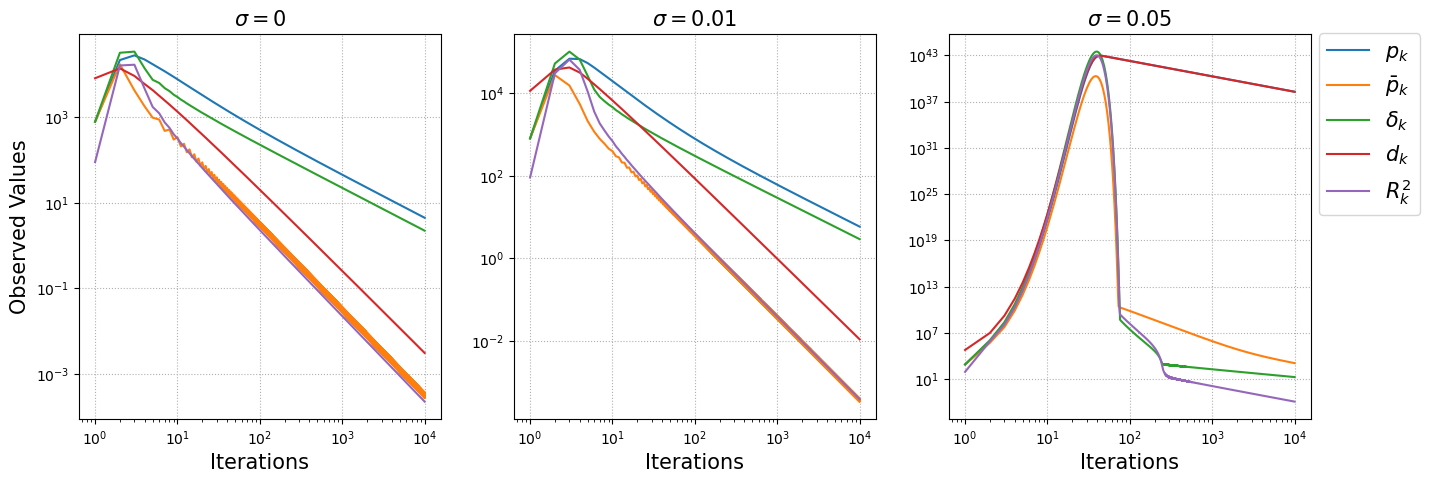

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 5))

ax1.loglog(1:T_sigma, primal_values1 - zeros(T_sigma))
ax1.loglog(1:T_sigma, average_iterate_primal_values1 - zeros(T_sigma))
ax1.loglog(1:T_sigma, f_list1 - zeros(T_sigma)) #f(x_k)-p*
ax1.loglog(1:T_sigma, zeros(T_sigma)-dual_values1)
ax1.loglog(1:T_sigma, distance_values1 - zeros(T_sigma))
ax1.grid(linestyle =":")
ax1.set_ylabel("Observed Values",fontsize=15)
ax1.set_xlabel("Iterations",fontsize=15)
ax1.set_title(L"\sigma = 0",fontsize=15)

ax2.loglog(1:T_sigma, primal_values2 - zeros(T_sigma))
ax2.loglog(1:T_sigma, average_iterate_primal_values2 - zeros(T_sigma))
ax2.loglog(1:T_sigma, f_list2 - zeros(T_sigma))
ax2.loglog(1:T_sigma, zeros(T_sigma)-dual_values2)
ax2.loglog(1:T_sigma, distance_values2 - zeros(T_sigma))
ax2.set_xlabel("Iterations",fontsize=15)
ax2.grid(linestyle =":")
ax2.set_title(L"\sigma = 0.01",fontsize=15)

ax3.loglog(1:T_sigma, primal_values3 - zeros(T_sigma), label=L"p_k")
ax3.loglog(1:T_sigma, average_iterate_primal_values3 - zeros(T_sigma), label=L"\bar p_k")
ax3.loglog(1:T_sigma, f_list3 - zeros(T_sigma), label=L"\delta_k")
ax3.loglog(1:T_sigma, zeros(T_sigma)-dual_values3, label=L"d_k")
ax3.loglog(1:T_sigma, distance_values3 - zeros(T_sigma), label=L"R_k^2")
ax3.set_xlabel("Iterations",fontsize=15)
ax3.grid(linestyle =":")
ax3.set_title(L"\sigma = 0.05",fontsize=15)

fig.legend(loc="center right", ncol=1, bbox_to_anchor=(0.92, 0.7),fontsize=15)
fig.subplots_adjust(right=0.85)
savefig("figure21_sigma_before",bbox_inches ="tight",pad_inches = 0)

## $\sigma=0$, after modification on $\lambda$

In [11]:
sigma=0

A1_sigma = A1(xtrue,n,m)
A2_sigma = A2(xtrue,n,m,sigma)
b1_sigma = A1_sigma*xtrue
b2_sigma = A2_sigma*xtrue
obj_sigma = x -> norm(A1_sigma*x-b1_sigma,p1)^p1 + norm(A2_sigma*x-b2_sigma,p2)^p2
objGrad_sigma = x -> ForwardDiff.gradient(obj_sigma, x)
mu_sigma = eigmin(A2_sigma'*A2_sigma)
M1_sigma = eigmax(A2_sigma'*A2_sigma)

T_sigma = 10000
lambda_list_sigma = [i*1.00 for i in 1:T_sigma+1]
lambda_list_sigma[1] = 0.5*(M1_sigma/mu_sigma)^2
beta_sigma =0

primal_values4, dual_values4,average_iterate_primal_values4,f_list4,_,distance_values4 = subgradientMethod(obj_sigma, objGrad_sigma, xtrue, mu_sigma, T_sigma, n, lambda_list_sigma, beta_sigma)
primal_gap_bound4,dual_gap_bound4,distance_optimal_bound4=three_important_bounds(lambda_list_sigma,A1_sigma,A2_sigma,beta_sigma,xtrue,zeros(n),T_sigma)


1
1.0
0


([989641.5440863206, 831298.8970325092, 672301.9415197979, 564676.3562303664, 487634.7523086373, 429688.3419651397, 384435.3566189451, 348059.5720855145, 318145.72608159756, 293088.82302433345  …  395.83216257441893, 395.7925818265184, 395.753008993874, 395.71344407411164, 395.6738870648581, 395.6343379637412, 395.59479676838953, 395.5552634764328, 395.5157380855016, 395.4762205932274], [8224.630330833043, 635015.5142814118, 583082.2220874808, 513022.83445376175, 453792.7897653445, 405751.34406866436, 366591.41273248167, 334236.7986523386, 307118.56974726624, 284084.9981274941  …  395.8223316997744, 395.7827529194261, 395.74318205374334, 395.70361910035217, 395.66406405687974, 395.62451692095397, 395.5849776902038, 395.54544636225916, 395.5059229347508, 395.46640740531046], [989641.5440863206, 831298.8970325092, 672301.9415197979, 564676.3562303664, 487634.7523086373, 429688.3419651397, 384435.3566189451, 348059.5720855145, 318145.72608159756, 293088.82302433345  …  395.83216257441893,

## $\sigma=0.01$, after modification on $\lambda$

In [12]:
sigma=0.01

A1_sigma = A1(xtrue,n,m)
A2_sigma = A2(xtrue,n,m,sigma)
b1_sigma = A1_sigma*xtrue
b2_sigma = A2_sigma*xtrue
obj_sigma = x -> norm(A1_sigma*x-b1_sigma,p1)^p1 + norm(A2_sigma*x-b2_sigma,p2)^p2
objGrad_sigma = x -> ForwardDiff.gradient(obj_sigma, x)
mu_sigma = eigmin(A2_sigma'*A2_sigma)
M1_sigma = eigmax(A2_sigma'*A2_sigma)

T_sigma = 10000
lambda_list_sigma = [i*1.0 for i in 1:T_sigma+1]
lambda_list_sigma[1] = 0.5*(M1_sigma/mu_sigma)^2
beta_sigma =0

primal_values5, dual_values5,average_iterate_primal_values5,f_list5,_,distance_values5 = subgradientMethod(obj_sigma, objGrad_sigma, xtrue, mu_sigma, T_sigma, n, lambda_list_sigma, beta_sigma)
primal_gap_bound5,dual_gap_bound5,distance_optimal_bound5=three_important_bounds(lambda_list_sigma,A1_sigma,A2_sigma,beta_sigma,xtrue,zeros(n),T_sigma)


2
1.7346900044555613
874.176907686997


([1.3186871664729286e6, 995414.3623622606, 816700.6626900315, 696835.300333105, 609194.9657362143, 541833.5852214824, 488263.8961360204, 444565.23680073285, 408199.565949496, 377441.28393241455  …  527.194153229886, 527.1414386780318, 527.0887346675827, 527.0360411953766, 526.9833582582532, 526.9306858530533, 526.8780239766189, 526.8253726257933, 526.772731797421, 526.7201014883478], [11824.896657932082, 434355.7232474402, 514410.0435426096, 509652.8612364638, 482376.1427492343, 450398.5328197163, 419282.9716564857, 390701.52434966515, 364989.1430895086, 342015.8811521304  …  527.1547608533037, 527.1020541854438, 527.0493580566219, 526.9966724636777, 526.9439974034514, 526.8913328727847, 526.8386788685207, 526.7860353875035, 526.7334024265788, 526.6807799825932], [1.7563628765460413e6, 1.3257949855612817e6, 1.087765742830386e6, 928116.7540633699, 811388.3638222168, 721669.5654165179, 650319.9567982173, 592117.5984506988, 543682.0665916601, 502715.0305465387  …  702.171267763002, 702.10

## $\sigma=0.05$, after modification on $\lambda$

In [13]:
sigma=0.05

A1_sigma = A1(xtrue,n,m)
A2_sigma = A2(xtrue,n,m,sigma)
b1_sigma = A1_sigma*xtrue
b2_sigma = A2_sigma*xtrue
obj_sigma = x -> norm(A1_sigma*x-b1_sigma,p1)^p1 + norm(A2_sigma*x-b2_sigma,p2)^p2
objGrad_sigma = x -> ForwardDiff.gradient(obj_sigma, x)
mu_sigma = eigmin(A2_sigma'*A2_sigma)
M1_sigma = eigmax(A2_sigma'*A2_sigma)

T_sigma = 10000
lambda_list_sigma = [i*1.0 for i in 1:T_sigma+1]
lambda_list_sigma[1] = 0.5*(M1_sigma/mu_sigma)^2
beta_sigma =0

primal_values6, dual_values6,average_iterate_primal_values6,f_list6,_,distance_values6 = subgradientMethod(obj_sigma, objGrad_sigma, xtrue, mu_sigma, T_sigma, n, lambda_list_sigma, beta_sigma)
primal_gap_bound6,dual_gap_bound6,distance_optimal_bound6=three_important_bounds(lambda_list_sigma,A1_sigma,A2_sigma,beta_sigma,xtrue,zeros(n),T_sigma)


2
20.000253642613572
3.1171029937138697e6


([6.524194543340987e6, 6.460238184305627e6, 6.367094256076581e6, 6.247622886203667e6, 6.105206725335147e6, 5.943545817860891e6, 5.766457660807004e6, 5.577699428719316e6, 5.380823624954491e6, 5.179072367829189e6  …  2622.1440910161486, 2621.880004096229, 2621.6159703659782, 2621.3519898093286, 2621.088062410219, 2620.824188152595, 2620.5603670204077, 2620.296598997616, 2620.032884068184, 2619.7692222160836], [77341.0251858873, 77213.29605669915, 77477.17669461283, 78378.33161413949, 80099.98186005304, 82756.37846832188, 86393.37241858372, 90994.85699306354, 96493.29308235404, 102782.38223298182  …  2596.3122301094945, 2596.053313160142, 2595.7944478485447, 2595.535634159255, 2595.2768720768336, 2595.018161585845, 2594.7595026708623, 2594.5008953164634, 2594.242339507232, 2593.9838352277584], [4.290789361102929e7, 4.2487269634995505e7, 4.1874686773400046e7, 4.1088955325017184e7, 4.015232208417143e7, 3.908912125947381e7, 3.792445951430912e7, 3.668304678714097e7, 3.5388246948416196e7, 3.40

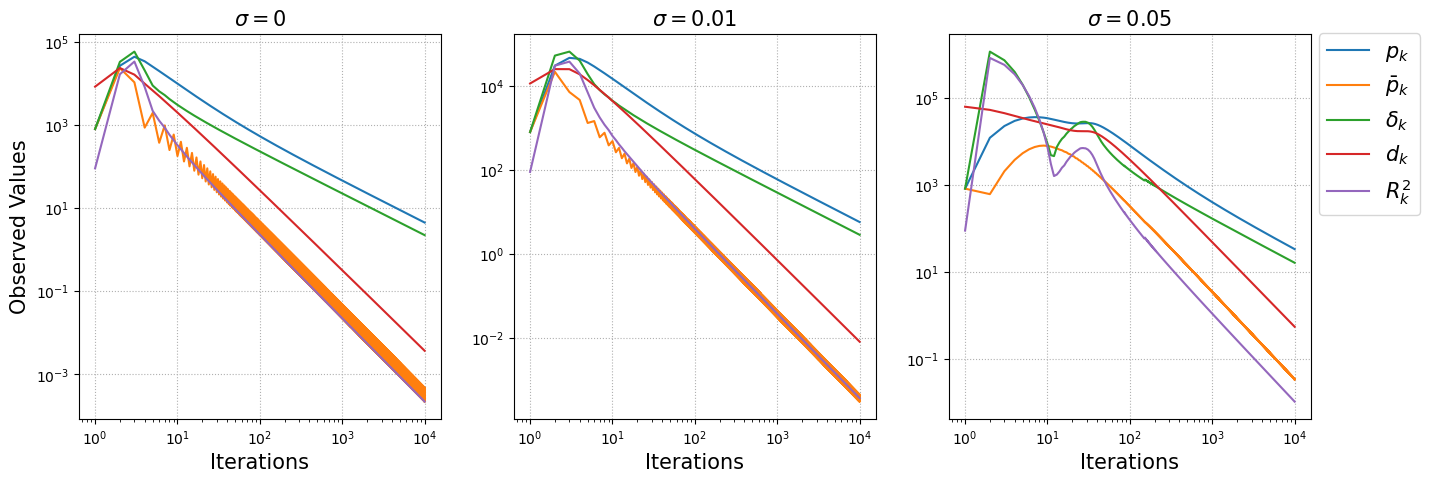

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 5))

ax1.loglog(1:T_sigma, primal_values4 - zeros(T_sigma))
ax1.loglog(1:T_sigma, average_iterate_primal_values4 - zeros(T_sigma))
ax1.loglog(1:T_sigma, f_list4 - zeros(T_sigma)) #f(x_k)-p*
ax1.loglog(1:T_sigma, zeros(T_sigma)-dual_values4)
ax1.loglog(1:T_sigma, distance_values4 - zeros(T_sigma))
ax1.grid(linestyle =":")
ax1.set_ylabel("Observed Values",fontsize=15)
ax1.set_xlabel("Iterations",fontsize=15)
ax1.set_title(L"\sigma = 0",fontsize=15)

ax2.loglog(1:T_sigma, primal_values5 - zeros(T_sigma))
ax2.loglog(1:T_sigma, average_iterate_primal_values5 - zeros(T_sigma))
ax2.loglog(1:T_sigma, f_list5 - zeros(T_sigma))
ax2.loglog(1:T_sigma, zeros(T_sigma)-dual_values5)
ax2.loglog(1:T_sigma, distance_values5 - zeros(T_sigma))
ax2.set_xlabel("Iterations",fontsize=15)
ax2.grid(linestyle =":")
ax2.set_title(L"\sigma = 0.01",fontsize=15)

ax3.loglog(1:T_sigma, primal_values6 - zeros(T_sigma), label=L"p_k")
ax3.loglog(1:T_sigma, average_iterate_primal_values6 - zeros(T_sigma), label=L"\bar p_k")
ax3.loglog(1:T_sigma, f_list6 - zeros(T_sigma), label=L"\delta_k")
ax3.loglog(1:T_sigma, zeros(T_sigma)-dual_values6, label=L"d_k")
ax3.loglog(1:T_sigma, distance_values6 - zeros(T_sigma), label=L"R_k^2")
ax3.set_xlabel("Iterations",fontsize=15)
ax3.grid(linestyle =":")
ax3.set_title(L"\sigma = 0.05",fontsize=15)

fig.legend(loc="center right", ncol=1, bbox_to_anchor=(0.92, 0.7),fontsize=15)
fig.subplots_adjust(right=0.85)
savefig("figure22_sigma_After_modify_lambda",bbox_inches ="tight",pad_inches = 0)

## Section 1.1

When $\lambda_i = i$, $\sigma = 0$, comparing different $\bar\beta$.

In [103]:
sigma=0

A1_sigma = A1(xtrue,n,m)
A2_sigma = A2(xtrue,n,m,sigma)
b1_sigma = A1_sigma*xtrue
b2_sigma = A2_sigma*xtrue
obj_sigma = x -> norm(A1_sigma*x-b1_sigma,p1)^p1 + norm(A2_sigma*x-b2_sigma,p2)^p2
objGrad_sigma = x -> ForwardDiff.gradient(obj_sigma, x)
mu_sigma = eigmin(A2_sigma'*A2_sigma)

T_sigma = 10000
lambda_list_sigma = [i for i in 1:T_sigma+1]
beta_sigma1 = 0
beta_sigma2 = 1
beta_sigma3 = 5
beta_sigma4 = 50
beta_sigma5 = 100
beta_sigma6 = 1000
primal_values1, dual_values1,_,_,_,distance_values1 = subgradientMethod(obj_sigma, objGrad_sigma, xtrue, mu_sigma, T_sigma, n, lambda_list_sigma, beta_sigma1)
primal_gap_bound1,dual_gap_bound1,distance_optimal_bound1=three_important_bounds(lambda_list_sigma,A1_sigma,A2_sigma,beta_sigma1,xtrue,zeros(n),T_sigma)
primal_values2, dual_values2,_,_,_,distance_values2 = subgradientMethod(obj_sigma, objGrad_sigma, xtrue, mu_sigma, T_sigma, n, lambda_list_sigma, beta_sigma2)
primal_gap_bound2,dual_gap_bound2,distance_optimal_bound2=three_important_bounds(lambda_list_sigma,A1_sigma,A2_sigma,beta_sigma2,xtrue,zeros(n),T_sigma)
primal_values3, dual_values3,_,_,_,distance_values3 = subgradientMethod(obj_sigma, objGrad_sigma, xtrue, mu_sigma, T_sigma, n, lambda_list_sigma, beta_sigma3)
primal_gap_bound3,dual_gap_bound3,distance_optimal_bound3=three_important_bounds(lambda_list_sigma,A1_sigma,A2_sigma,beta_sigma3,xtrue,zeros(n),T_sigma)
primal_values4, dual_values4,_,_,_,distance_values4 = subgradientMethod(obj_sigma, objGrad_sigma, xtrue, mu_sigma, T_sigma, n, lambda_list_sigma, beta_sigma4)
primal_gap_bound4,dual_gap_bound4,distance_optimal_bound4=three_important_bounds(lambda_list_sigma,A1_sigma,A2_sigma,beta_sigma4,xtrue,zeros(n),T_sigma)
primal_values5, dual_values5,_,_,_,distance_values5 = subgradientMethod(obj_sigma, objGrad_sigma, xtrue, mu_sigma, T_sigma, n, lambda_list_sigma, beta_sigma5)
primal_gap_bound5,dual_gap_bound5,distance_optimal_bound5=three_important_bounds(lambda_list_sigma,A1_sigma,A2_sigma,beta_sigma5,xtrue,zeros(n),T_sigma)
primal_values6, dual_values6,_,_,_,distance_values6 = subgradientMethod(obj_sigma, objGrad_sigma, xtrue, mu_sigma, T_sigma, n, lambda_list_sigma, beta_sigma6)
primal_gap_bound6,dual_gap_bound6,distance_optimal_bound6=three_important_bounds(lambda_list_sigma,A1_sigma,A2_sigma,beta_sigma6,xtrue,zeros(n),T_sigma)


1
1.0
0
1
1.0
0
1
1.0
0
1
1.0
0
1
1.0
0
1
1.0
0


([90592.96699694011, 31513.230998430114, 17232.224163359668, 11907.083478746606, 9563.082818485129, 8492.407488093246, 8054.006688201315, 7962.454012035294, 8074.608931499409, 8312.041592961077  …  393.22341853042286, 393.184359102813, 393.1453074342077, 393.1062635222952, 393.06722736476456, 393.02819895930617, 392.98917830361086, 392.9501653953706, 392.9111602322784, 392.87216281202797], [8224.630330833043, 2.043439501856011e7, 1.5564056564002478e7, 1.1416516211464807e7, 8.64059534091518e6, 6.77440991367699e6, 5.478230626724952e6, 4.546816127394981e6, 3.856746687100206e6, 3.3317127663012547e6  …  416.4070154019706, 416.36331699468366, 416.31962773861846, 416.2759476309064, 416.2322766686799, 416.1886148490726, 416.1449621692193, 416.10131862625605, 416.05768421732006, 416.0140589395498], [90.50246453240771, 94.25692222860454, 102.77668487093241, 117.89191563115452, 141.3263470712088, 174.67243609202563, 219.3698319743549, 276.6875911518056, 347.7104324569124, 433.3291825714305  …  39

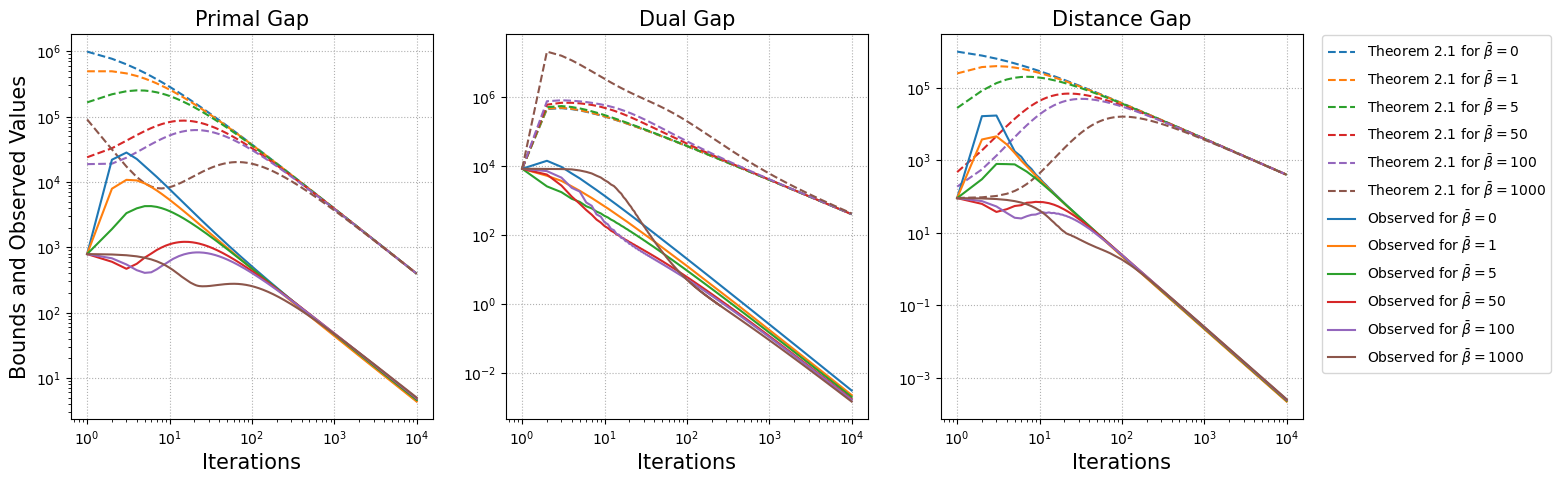

In [104]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 5))
ax1.loglog(1:T_sigma, primal_gap_bound1 - zeros(T_sigma),linestyle ="--",color= "tab:blue")
ax1.loglog(1:T_sigma, primal_gap_bound2 - zeros(T_sigma),linestyle ="--",color= "tab:orange")
ax1.loglog(1:T_sigma, primal_gap_bound3 - zeros(T_sigma),linestyle ="--",color= "tab:green")
ax1.loglog(1:T_sigma, primal_gap_bound4 - zeros(T_sigma),linestyle ="--",color= "tab:red")
ax1.loglog(1:T_sigma, primal_gap_bound5 - zeros(T_sigma),linestyle ="--",color= "tab:purple")
ax1.loglog(1:T_sigma, primal_gap_bound6 - zeros(T_sigma),linestyle ="--",color= "tab:brown")
ax1.loglog(1:T_sigma, primal_values1 - zeros(T_sigma),color= "tab:blue")
ax1.loglog(1:T_sigma, primal_values2 - zeros(T_sigma),color= "tab:orange")
ax1.loglog(1:T_sigma, primal_values3 - zeros(T_sigma),color= "tab:green")
ax1.loglog(1:T_sigma, primal_values4 - zeros(T_sigma),color= "tab:red")
ax1.loglog(1:T_sigma, primal_values5 - zeros(T_sigma),color= "tab:purple")
ax1.loglog(1:T_sigma, primal_values6 - zeros(T_sigma),color= "tab:brown")
ax1.set_xlabel("Iterations",fontsize=15)
ax1.grid(linestyle =":")
ax1.set_title("Primal Gap",fontsize=15)

ax2.loglog(1:T_sigma, dual_gap_bound1 - zeros(T_sigma),linestyle ="--",color= "tab:blue")
ax2.loglog(1:T_sigma, dual_gap_bound2 - zeros(T_sigma),linestyle ="--",color= "tab:orange")
ax2.loglog(1:T_sigma, dual_gap_bound3 - zeros(T_sigma),linestyle ="--",color= "tab:green")
ax2.loglog(1:T_sigma, dual_gap_bound4 - zeros(T_sigma),linestyle ="--",color= "tab:red")
ax2.loglog(1:T_sigma, dual_gap_bound5 - zeros(T_sigma),linestyle ="--",color= "tab:purple")
ax2.loglog(1:T_sigma, dual_gap_bound6 - zeros(T_sigma),linestyle ="--",color= "tab:brown")
ax2.loglog(1:T_sigma, zeros(T_sigma)-dual_values1,color= "tab:blue")
ax2.loglog(1:T_sigma, zeros(T_sigma)-dual_values2,color= "tab:orange")
ax2.loglog(1:T_sigma, zeros(T_sigma)-dual_values3,color= "tab:green")
ax2.loglog(1:T_sigma, zeros(T_sigma)-dual_values4,color= "tab:red")
ax2.loglog(1:T_sigma, zeros(T_sigma)-dual_values5,color= "tab:purple")
ax2.loglog(1:T_sigma, zeros(T_sigma)-dual_values6,color= "tab:brown")
ax2.set_xlabel("Iterations",fontsize=15)
ax2.grid(linestyle =":")
ax2.set_title("Dual Gap",fontsize=15)


ax3.loglog(1:T_sigma, distance_optimal_bound1 - zeros(T_sigma), label=L"\mathrm{Theorem\ 2.1\ for\ }\bar\beta=0",linestyle ="--",color= "tab:blue")
ax3.loglog(1:T_sigma, distance_optimal_bound2 - zeros(T_sigma), label=L"\mathrm{Theorem\ 2.1\ for\ }\bar\beta=1",linestyle ="--",color= "tab:orange")
ax3.loglog(1:T_sigma, distance_optimal_bound3 - zeros(T_sigma), label=L"\mathrm{Theorem\ 2.1\ for\ }\bar\beta=5",linestyle ="--",color= "tab:green")
ax3.loglog(1:T_sigma, distance_optimal_bound4 - zeros(T_sigma), label=L"\mathrm{Theorem\ 2.1\ for\ }\bar\beta=50",linestyle ="--",color= "tab:red")
ax3.loglog(1:T_sigma, distance_optimal_bound5 - zeros(T_sigma), label=L"\mathrm{Theorem\ 2.1\ for\ }\bar\beta=100",linestyle ="--",color= "tab:purple")
ax3.loglog(1:T_sigma, distance_optimal_bound6 - zeros(T_sigma), label=L"\mathrm{Theorem\ 2.1\ for\ }\bar\beta=1000",linestyle ="--",color= "tab:brown")
ax3.loglog(1:T_sigma, distance_values1 - zeros(T_sigma), label=L"\mathrm{Observed\ for\ }\bar\beta=0",color= "tab:blue")
ax3.loglog(1:T_sigma, distance_values2 - zeros(T_sigma), label=L"\mathrm{Observed\ for\ }\bar\beta=1",color= "tab:orange")
ax3.loglog(1:T_sigma, distance_values3 - zeros(T_sigma), label=L"\mathrm{Observed\ for\ }\bar\beta=5",color= "tab:green")
ax3.loglog(1:T_sigma, distance_values4 - zeros(T_sigma), label=L"\mathrm{Observed\ for\ }\bar\beta=50",color= "tab:red")
ax3.loglog(1:T_sigma, distance_values5 - zeros(T_sigma), label=L"\mathrm{Observed\ for\ }\bar\beta=100",color= "tab:purple")
ax3.loglog(1:T_sigma, distance_values6 - zeros(T_sigma), label=L"\mathrm{Observed\ for\ }\bar\beta=1000",color= "tab:brown")
ax3.grid(linestyle =":")
ax3.set_xlabel("Iterations",fontsize=15)
ax3.set_title("Distance Gap",fontsize=15)

ax1.set_ylabel("Bounds and Observed Values",fontsize=15)
fig.legend(loc="center right", ncol=1, bbox_to_anchor=(1.0, 0.54),fontsize=10)
fig.subplots_adjust(right=0.85)
savefig("figure23_different_beta",bbox_inches ="tight",pad_inches = 0)



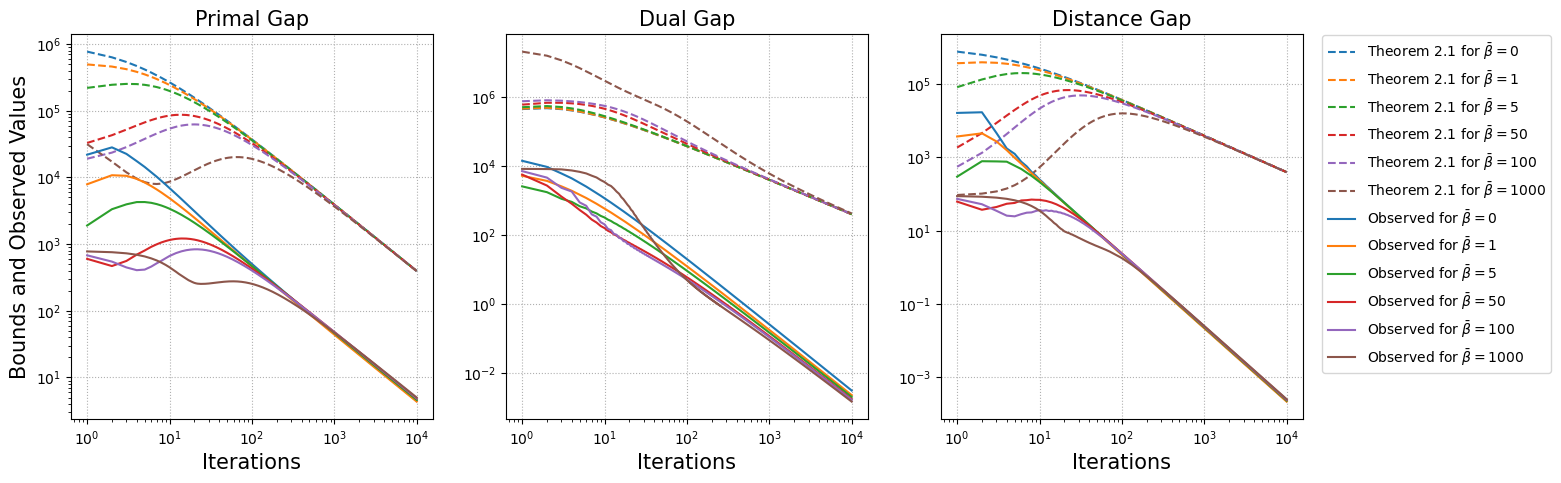

In [92]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 5))
ax1.loglog(1:T_sigma-1, primal_gap_bound1[2:T_sigma] - zeros(T_sigma-1),linestyle ="--",color= "tab:blue")
ax1.loglog(1:T_sigma-1, primal_gap_bound2[2:T_sigma] - zeros(T_sigma-1),linestyle ="--",color= "tab:orange")
ax1.loglog(1:T_sigma-1, primal_gap_bound3[2:T_sigma] - zeros(T_sigma-1),linestyle ="--",color= "tab:green")
ax1.loglog(1:T_sigma-1, primal_gap_bound4[2:T_sigma] - zeros(T_sigma-1),linestyle ="--",color= "tab:red")
ax1.loglog(1:T_sigma-1, primal_gap_bound5[2:T_sigma] - zeros(T_sigma-1),linestyle ="--",color= "tab:purple")
ax1.loglog(1:T_sigma-1, primal_gap_bound6[2:T_sigma] - zeros(T_sigma-1),linestyle ="--",color= "tab:brown")
ax1.loglog(1:T_sigma-1, primal_values1[2:T_sigma] - zeros(T_sigma-1),color= "tab:blue")
ax1.loglog(1:T_sigma-1, primal_values2[2:T_sigma] - zeros(T_sigma-1),color= "tab:orange")
ax1.loglog(1:T_sigma-1, primal_values3[2:T_sigma] - zeros(T_sigma-1),color= "tab:green")
ax1.loglog(1:T_sigma-1, primal_values4[2:T_sigma] - zeros(T_sigma-1),color= "tab:red")
ax1.loglog(1:T_sigma-1, primal_values5[2:T_sigma] - zeros(T_sigma-1),color= "tab:purple")
ax1.loglog(1:T_sigma-1, primal_values6[2:T_sigma] - zeros(T_sigma-1),color= "tab:brown")
ax1.set_xlabel("Iterations",fontsize=15)
ax1.grid(linestyle =":")
ax1.set_title("Primal Gap",fontsize=15)

ax2.loglog(1:T_sigma-1, dual_gap_bound1[2:T_sigma] - zeros(T_sigma-1),linestyle ="--",color= "tab:blue")
ax2.loglog(1:T_sigma-1, dual_gap_bound2[2:T_sigma] - zeros(T_sigma-1),linestyle ="--",color= "tab:orange")
ax2.loglog(1:T_sigma-1, dual_gap_bound3[2:T_sigma] - zeros(T_sigma-1),linestyle ="--",color= "tab:green")
ax2.loglog(1:T_sigma-1, dual_gap_bound4[2:T_sigma]- zeros(T_sigma-1),linestyle ="--",color= "tab:red")
ax2.loglog(1:T_sigma-1, dual_gap_bound5[2:T_sigma] - zeros(T_sigma-1),linestyle ="--",color= "tab:purple")
ax2.loglog(1:T_sigma-1, dual_gap_bound6[2:T_sigma] - zeros(T_sigma-1),linestyle ="--",color= "tab:brown")
ax2.loglog(1:T_sigma-1, zeros(T_sigma-1)-dual_values1[2:T_sigma],color= "tab:blue")
ax2.loglog(1:T_sigma-1, zeros(T_sigma-1)-dual_values2[2:T_sigma],color= "tab:orange")
ax2.loglog(1:T_sigma-1, zeros(T_sigma-1)-dual_values3[2:T_sigma],color= "tab:green")
ax2.loglog(1:T_sigma-1, zeros(T_sigma-1)-dual_values4[2:T_sigma],color= "tab:red")
ax2.loglog(1:T_sigma-1, zeros(T_sigma-1)-dual_values5[2:T_sigma],color= "tab:purple")
ax2.loglog(1:T_sigma-1, zeros(T_sigma-1)-dual_values6[2:T_sigma],color= "tab:brown")
ax2.set_xlabel("Iterations",fontsize=15)
ax2.grid(linestyle =":")
ax2.set_title("Dual Gap",fontsize=15)


ax3.loglog(1:T_sigma-1, distance_optimal_bound1[2:T_sigma] - zeros(T_sigma-1), label=L"\mathrm{Theorem\ 2.1\ for\ }\bar\beta=0",linestyle ="--",color= "tab:blue")
ax3.loglog(1:T_sigma-1, distance_optimal_bound2[2:T_sigma] - zeros(T_sigma-1), label=L"\mathrm{Theorem\ 2.1\ for\ }\bar\beta=1",linestyle ="--",color= "tab:orange")
ax3.loglog(1:T_sigma-1, distance_optimal_bound3[2:T_sigma] - zeros(T_sigma-1), label=L"\mathrm{Theorem\ 2.1\ for\ }\bar\beta=5",linestyle ="--",color= "tab:green")
ax3.loglog(1:T_sigma-1, distance_optimal_bound4[2:T_sigma] - zeros(T_sigma-1), label=L"\mathrm{Theorem\ 2.1\ for\ }\bar\beta=50",linestyle ="--",color= "tab:red")
ax3.loglog(1:T_sigma-1, distance_optimal_bound5[2:T_sigma] - zeros(T_sigma-1), label=L"\mathrm{Theorem\ 2.1\ for\ }\bar\beta=100",linestyle ="--",color= "tab:purple")
ax3.loglog(1:T_sigma-1, distance_optimal_bound6[2:T_sigma] - zeros(T_sigma-1), label=L"\mathrm{Theorem\ 2.1\ for\ }\bar\beta=1000",linestyle ="--",color= "tab:brown")
ax3.loglog(1:T_sigma-1, distance_values1[2:T_sigma] - zeros(T_sigma-1), label=L"\mathrm{Observed\ for\ }\bar\beta=0",color= "tab:blue")
ax3.loglog(1:T_sigma-1, distance_values2[2:T_sigma] - zeros(T_sigma-1), label=L"\mathrm{Observed\ for\ }\bar\beta=1",color= "tab:orange")
ax3.loglog(1:T_sigma-1, distance_values3[2:T_sigma] - zeros(T_sigma-1), label=L"\mathrm{Observed\ for\ }\bar\beta=5",color= "tab:green")
ax3.loglog(1:T_sigma-1, distance_values4[2:T_sigma] - zeros(T_sigma-1), label=L"\mathrm{Observed\ for\ }\bar\beta=50",color= "tab:red")
ax3.loglog(1:T_sigma-1, distance_values5[2:T_sigma] - zeros(T_sigma-1), label=L"\mathrm{Observed\ for\ }\bar\beta=100",color= "tab:purple")
ax3.loglog(1:T_sigma-1, distance_values6[2:T_sigma] - zeros(T_sigma-1), label=L"\mathrm{Observed\ for\ }\bar\beta=1000",color= "tab:brown")
ax3.grid(linestyle =":")
ax3.set_xlabel("Iterations",fontsize=15)
ax3.set_title("Distance Gap",fontsize=15)

ax1.set_ylabel("Bounds and Observed Values",fontsize=15)
fig.legend(loc="center right", ncol=1, bbox_to_anchor=(1.0, 0.54),fontsize=10)
fig.subplots_adjust(right=0.85)
savefig("figure23_different_beta",bbox_inches ="tight",pad_inches = 0)

## Section 1.2

When $\beta = 0$, $\sigma = 0$, comparing different $\lambda$.

In [93]:
sigma=0

A1_sigma = A1(xtrue,n,m)
A2_sigma = A2(xtrue,n,m,sigma)
b1_sigma = A1_sigma*xtrue
b2_sigma = A2_sigma*xtrue
obj_sigma = x -> norm(A1_sigma*x-b1_sigma,p1)^p1 + norm(A2_sigma*x-b2_sigma,p2)^p2
objGrad_sigma = x -> ForwardDiff.gradient(obj_sigma, x)
mu_sigma = eigmin(A2_sigma'*A2_sigma)

T_sigma = 10000
lambda_list_sigma1 = [1 for i in 1:T_sigma+1]
lambda_list_sigma2 = [i for i in 1:T_sigma+1]
lambda_list_sigma3 = [i^2 for i in 1:T_sigma+1]
lambda_list_sigma4 = [i^3.0 for i in 1:T_sigma+1]
lambda_list_sigma5 = [i^4.0 for i in 1:T_sigma+1]
beta_sigma = 0

primal_values1, dual_values1,_,_,_,distance_values1 = subgradientMethod(obj_sigma, objGrad_sigma, xtrue, mu_sigma, T_sigma, n, lambda_list_sigma1, beta_sigma)
primal_gap_bound1,dual_gap_bound1,distance_optimal_bound1=three_important_bounds(lambda_list_sigma1,A1_sigma,A2_sigma,beta_sigma,xtrue,zeros(n),T_sigma)
primal_values2, dual_values2,_,_,_,distance_values2 = subgradientMethod(obj_sigma, objGrad_sigma, xtrue, mu_sigma, T_sigma, n, lambda_list_sigma2, beta_sigma)
primal_gap_bound2,dual_gap_bound2,distance_optimal_bound2=three_important_bounds(lambda_list_sigma2,A1_sigma,A2_sigma,beta_sigma,xtrue,zeros(n),T_sigma)
primal_values3, dual_values3,_,_,_,distance_values3 = subgradientMethod(obj_sigma, objGrad_sigma, xtrue, mu_sigma, T_sigma, n, lambda_list_sigma3, beta_sigma)
primal_gap_bound3,dual_gap_bound3,distance_optimal_bound3=three_important_bounds(lambda_list_sigma3,A1_sigma,A2_sigma,beta_sigma,xtrue,zeros(n),T_sigma)
primal_values4, dual_values4,_,_,_,distance_values4 = subgradientMethod(obj_sigma, objGrad_sigma, xtrue, mu_sigma, T_sigma, n, lambda_list_sigma4, beta_sigma)
primal_gap_bound4,dual_gap_bound4,distance_optimal_bound4=three_important_bounds(lambda_list_sigma4,A1_sigma,A2_sigma,beta_sigma,xtrue,zeros(n),T_sigma)
primal_values5, dual_values5,_,_,_,distance_values5 = subgradientMethod(obj_sigma, objGrad_sigma, xtrue, mu_sigma, T_sigma, n, lambda_list_sigma5, beta_sigma)
primal_gap_bound5,dual_gap_bound5,distance_optimal_bound5=three_important_bounds(lambda_list_sigma5,A1_sigma,A2_sigma,beta_sigma,xtrue,zeros(n),T_sigma)



1
1.0
0
1
1.0
0
1
1.0
0
1
1.0
0
1
1.0
0


([989641.5440863206, 934851.7008151056, 838244.5964502618, 749605.2361493631, 674393.5374530713, 611374.2626573615, 558373.5756999281, 513421.1937761967, 474930.26043978933, 441662.5296781851  …  618.8456920130797, 618.7837816498914, 618.7218836726973, 618.6599980777811, 618.5981248614273, 618.5362640199224, 618.4744155495542, 618.4125794466124, 618.3507557073873, 618.2889443281715], [8224.630330833043, 877121.2941236063, 828230.1381466343, 746832.871986212, 673391.0686954048, 610942.870607359, 558163.6918432653, 513309.3131430737, 474866.25359743915, 441623.78902710724  …  618.8456920130797, 618.7837816498914, 618.7218836726973, 618.6599980777811, 618.5981248614273, 618.5362640199224, 618.4744155495542, 618.4125794466124, 618.3507557073873, 618.2889443281715], [989641.5440863206, 934851.7008151056, 838244.5964502618, 749605.2361493631, 674393.5374530713, 611374.2626573615, 558373.5756999281, 513421.1937761967, 474930.26043978933, 441662.5296781851  …  618.8456920130797, 618.7837816498

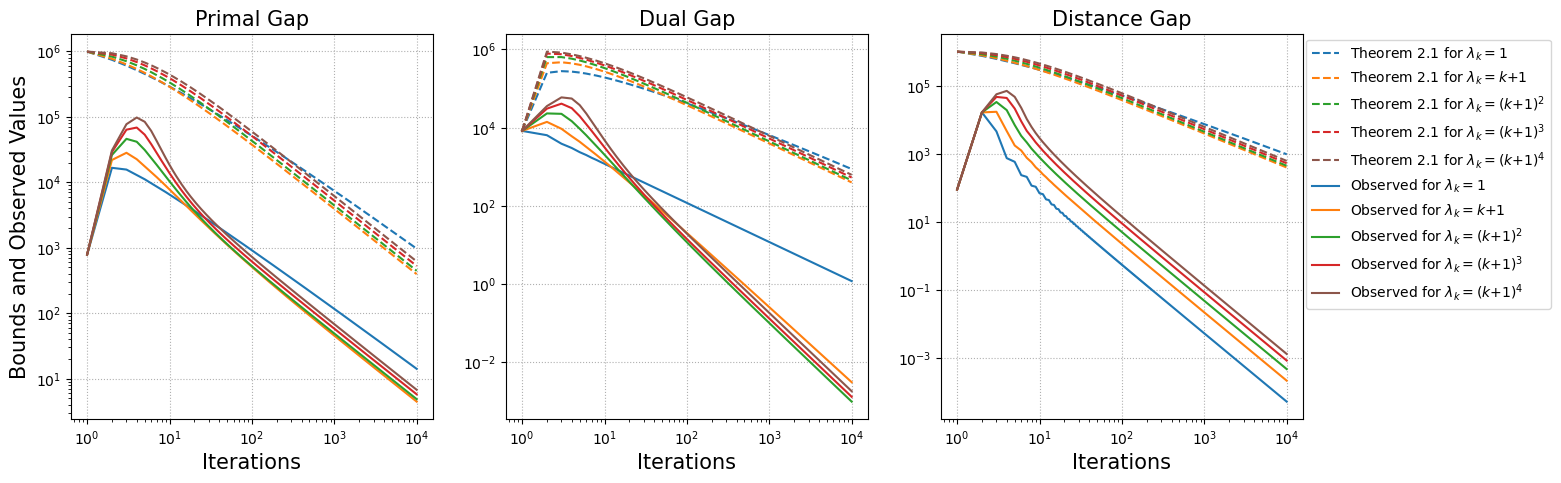

In [102]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 5))

ax1.loglog(1:T_sigma, primal_gap_bound1 - zeros(T_sigma),linestyle ="--",color="tab:blue")
ax1.loglog(1:T_sigma, primal_gap_bound2 - zeros(T_sigma),linestyle ="--",color="tab:orange")
ax1.loglog(1:T_sigma, primal_gap_bound3 - zeros(T_sigma),linestyle ="--",color="tab:green")
ax1.loglog(1:T_sigma, primal_gap_bound4 - zeros(T_sigma),linestyle ="--",color="tab:red")
ax1.loglog(1:T_sigma, primal_gap_bound5 - zeros(T_sigma),linestyle ="--",color="tab:brown")
ax1.loglog(1:T_sigma, primal_values1 - zeros(T_sigma),color="tab:blue")
ax1.loglog(1:T_sigma, primal_values2 - zeros(T_sigma),color="tab:orange")
ax1.loglog(1:T_sigma, primal_values3 - zeros(T_sigma),color="tab:green")
ax1.loglog(1:T_sigma, primal_values4 - zeros(T_sigma),color="tab:red")
ax1.loglog(1:T_sigma, primal_values5 - zeros(T_sigma),color="tab:brown")
ax1.set_xlabel("Iterations",fontsize=15)
ax1.set_ylabel("Bounds and Observed Values",fontsize=15)
ax1.grid(linestyle =":")
ax1.set_title("Primal Gap",fontsize=15)

ax2.loglog(1:T_sigma, dual_gap_bound1 - zeros(T_sigma),linestyle ="--",color="tab:blue")
ax2.loglog(1:T_sigma, dual_gap_bound2 - zeros(T_sigma),linestyle ="--",color="tab:orange")
ax2.loglog(1:T_sigma, dual_gap_bound3 - zeros(T_sigma),linestyle ="--",color="tab:green")
ax2.loglog(1:T_sigma, dual_gap_bound4 - zeros(T_sigma),linestyle ="--",color="tab:red")
ax2.loglog(1:T_sigma, dual_gap_bound5 - zeros(T_sigma),linestyle ="--",color="tab:brown")
ax2.loglog(1:T_sigma, zeros(T_sigma)-dual_values1,color="tab:blue")
ax2.loglog(1:T_sigma, zeros(T_sigma)-dual_values2,color="tab:orange")
ax2.loglog(1:T_sigma, zeros(T_sigma)-dual_values3,color="tab:green")
ax2.loglog(1:T_sigma, zeros(T_sigma)-dual_values4,color="tab:red")
ax2.loglog(1:T_sigma, zeros(T_sigma)-dual_values5,color="tab:brown")
ax2.set_xlabel("Iterations",fontsize=15)
ax2.grid(linestyle =":")
ax2.set_title("Dual Gap",fontsize=15)

ax3.loglog(1:T_sigma, distance_optimal_bound1 - zeros(T_sigma), label=L"\mathrm{Theorem\ 2.1\ for\ }\lambda_k=1",linestyle ="--",color="tab:blue")
ax3.loglog(1:T_sigma, distance_optimal_bound2 - zeros(T_sigma), label=L"\mathrm{Theorem\ 2.1\ for\ }\lambda_k{=}k{+}1",linestyle ="--",color="tab:orange")
ax3.loglog(1:T_sigma, distance_optimal_bound3 - zeros(T_sigma), label=L"\mathrm{Theorem\ 2.1\ for\ }\lambda_k{=}(k{+}1)^2",linestyle ="--",color="tab:green")
ax3.loglog(1:T_sigma, distance_optimal_bound4 - zeros(T_sigma), label=L"\mathrm{Theorem\ 2.1\ for\ }\lambda_k{=}(k{+}1)^3",linestyle ="--",color="tab:red")
ax3.loglog(1:T_sigma, distance_optimal_bound5 - zeros(T_sigma), label=L"\mathrm{Theorem\ 2.1\ for\ }\lambda_k{=}(k{+}1)^4",linestyle ="--",color="tab:brown")
ax3.loglog(1:T_sigma, distance_values1 - zeros(T_sigma), label=L"\mathrm{Observed\ for\ }\lambda_k=1",color="tab:blue")
ax3.loglog(1:T_sigma, distance_values2 - zeros(T_sigma), label=L"\mathrm{Observed\ for\ }\lambda_k{=}k{+}1",color="tab:orange")
ax3.loglog(1:T_sigma, distance_values3 - zeros(T_sigma), label=L"\mathrm{Observed\ for\ }\lambda_k{=}(k{+}1)^2",color="tab:green")
ax3.loglog(1:T_sigma, distance_values4 - zeros(T_sigma), label=L"\mathrm{Observed\ for\ }\lambda_k{=}(k{+}1)^3",color="tab:red")
ax3.loglog(1:T_sigma, distance_values5 - zeros(T_sigma), label=L"\mathrm{Observed\ for\ }\lambda_k{=}(k{+}1)^4",color="tab:brown")
ax3.set_xlabel("Iterations",fontsize=15)
ax3.grid(linestyle =":")
ax3.set_title("Distance Gap",fontsize=15)

fig.legend(loc="center right", ncol=1, bbox_to_anchor=(1, 0.6),fontsize=10)
fig.subplots_adjust(right=0.85)
savefig("figure24_different_lambda",bbox_inches ="tight",pad_inches = 0)

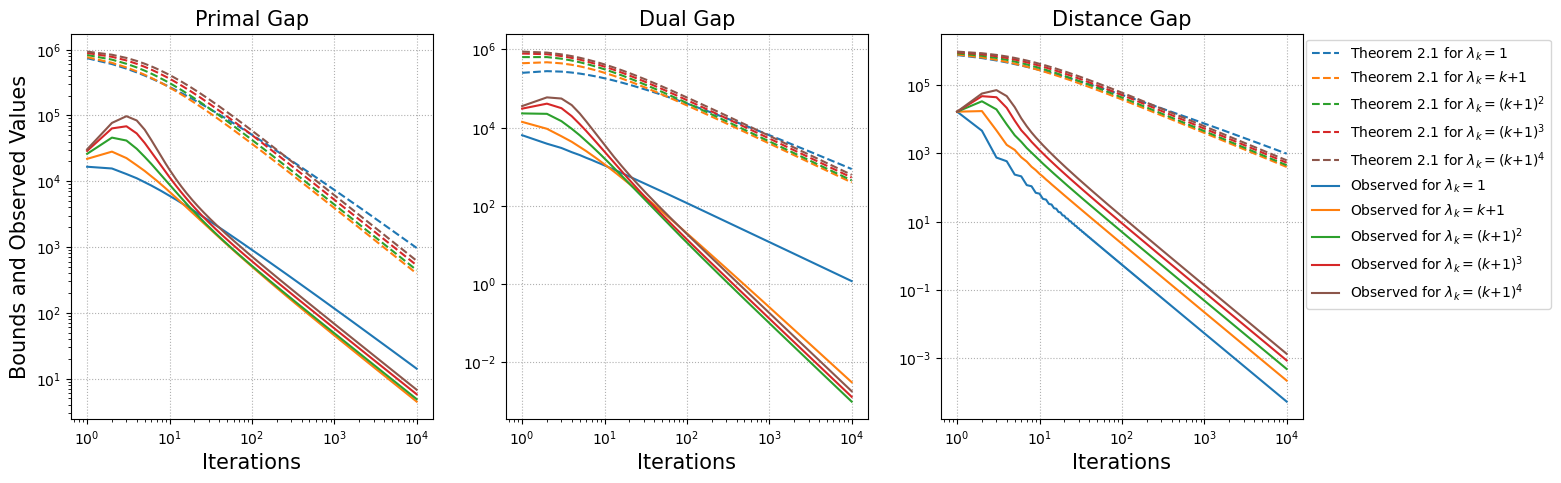

In [100]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 5))

ax1.loglog(1:T_sigma-1, primal_gap_bound1[2:T_sigma] - zeros(T_sigma-1),linestyle ="--",color="tab:blue")
ax1.loglog(1:T_sigma-1, primal_gap_bound2[2:T_sigma] - zeros(T_sigma-1),linestyle ="--",color="tab:orange")
ax1.loglog(1:T_sigma-1, primal_gap_bound3[2:T_sigma] - zeros(T_sigma-1),linestyle ="--",color="tab:green")
ax1.loglog(1:T_sigma-1, primal_gap_bound4[2:T_sigma] - zeros(T_sigma-1),linestyle ="--",color="tab:red")
ax1.loglog(1:T_sigma-1, primal_gap_bound5[2:T_sigma] - zeros(T_sigma-1),linestyle ="--",color="tab:brown")
ax1.loglog(1:T_sigma-1, primal_values1[2:T_sigma] - zeros(T_sigma-1),color="tab:blue")
ax1.loglog(1:T_sigma-1, primal_values2[2:T_sigma] - zeros(T_sigma-1),color="tab:orange")
ax1.loglog(1:T_sigma-1, primal_values3[2:T_sigma] - zeros(T_sigma-1),color="tab:green")
ax1.loglog(1:T_sigma-1, primal_values4[2:T_sigma] - zeros(T_sigma-1),color="tab:red")
ax1.loglog(1:T_sigma-1, primal_values5[2:T_sigma] - zeros(T_sigma-1),color="tab:brown")
ax1.set_xlabel("Iterations",fontsize=15)
ax1.set_ylabel("Bounds and Observed Values",fontsize=15)
ax1.grid(linestyle =":")
ax1.set_title("Primal Gap",fontsize=15)

ax2.loglog(1:T_sigma-1, dual_gap_bound1[2:T_sigma] - zeros(T_sigma-1),linestyle ="--",color="tab:blue")
ax2.loglog(1:T_sigma-1, dual_gap_bound2[2:T_sigma] - zeros(T_sigma-1),linestyle ="--",color="tab:orange")
ax2.loglog(1:T_sigma-1, dual_gap_bound3[2:T_sigma] - zeros(T_sigma-1),linestyle ="--",color="tab:green")
ax2.loglog(1:T_sigma-1, dual_gap_bound4[2:T_sigma] - zeros(T_sigma-1),linestyle ="--",color="tab:red")
ax2.loglog(1:T_sigma-1, dual_gap_bound5[2:T_sigma] - zeros(T_sigma-1),linestyle ="--",color="tab:brown")
ax2.loglog(1:T_sigma-1, zeros(T_sigma-1)-dual_values1[2:T_sigma],color="tab:blue")
ax2.loglog(1:T_sigma-1, zeros(T_sigma-1)-dual_values2[2:T_sigma],color="tab:orange")
ax2.loglog(1:T_sigma-1, zeros(T_sigma-1)-dual_values3[2:T_sigma],color="tab:green")
ax2.loglog(1:T_sigma-1, zeros(T_sigma-1)-dual_values4[2:T_sigma],color="tab:red")
ax2.loglog(1:T_sigma-1, zeros(T_sigma-1)-dual_values5[2:T_sigma],color="tab:brown")
ax2.set_xlabel("Iterations",fontsize=15)
ax2.grid(linestyle =":")
ax2.set_title("Dual Gap",fontsize=15)

ax3.loglog(1:T_sigma-1, distance_optimal_bound1[2:T_sigma] - zeros(T_sigma-1), label=L"\mathrm{Theorem\ 2.1\ for\ }\lambda_k=1",linestyle ="--",color="tab:blue")
ax3.loglog(1:T_sigma-1, distance_optimal_bound2[2:T_sigma] - zeros(T_sigma-1), label=L"\mathrm{Theorem\ 2.1\ for\ }\lambda_k{=}k{+}1",linestyle ="--",color="tab:orange")
ax3.loglog(1:T_sigma-1, distance_optimal_bound3[2:T_sigma] - zeros(T_sigma-1), label=L"\mathrm{Theorem\ 2.1\ for\ }\lambda_k{=}(k{+}1)^2",linestyle ="--",color="tab:green")
ax3.loglog(1:T_sigma-1, distance_optimal_bound4[2:T_sigma] - zeros(T_sigma-1), label=L"\mathrm{Theorem\ 2.1\ for\ }\lambda_k{=}(k{+}1)^3",linestyle ="--",color="tab:red")
ax3.loglog(1:T_sigma-1, distance_optimal_bound5[2:T_sigma] - zeros(T_sigma-1), label=L"\mathrm{Theorem\ 2.1\ for\ }\lambda_k{=}(k{+}1)^4",linestyle ="--",color="tab:brown")
ax3.loglog(1:T_sigma-1, distance_values1[2:T_sigma] - zeros(T_sigma-1), label=L"\mathrm{Observed\ for\ }\lambda_k=1",color="tab:blue")
ax3.loglog(1:T_sigma-1, distance_values2[2:T_sigma] - zeros(T_sigma-1), label=L"\mathrm{Observed\ for\ }\lambda_k{=}k{+}1",color="tab:orange")
ax3.loglog(1:T_sigma-1, distance_values3[2:T_sigma] - zeros(T_sigma-1), label=L"\mathrm{Observed\ for\ }\lambda_k{=}(k{+}1)^2",color="tab:green")
ax3.loglog(1:T_sigma-1, distance_values4[2:T_sigma] - zeros(T_sigma-1), label=L"\mathrm{Observed\ for\ }\lambda_k{=}(k{+}1)^3",color="tab:red")
ax3.loglog(1:T_sigma-1, distance_values5[2:T_sigma] - zeros(T_sigma-1), label=L"\mathrm{Observed\ for\ }\lambda_k{=}(k{+}1)^4",color="tab:brown")
ax3.set_xlabel("Iterations",fontsize=15)
ax3.grid(linestyle =":")
ax3.set_title("Distance Gap",fontsize=15)

fig.legend(loc="center right", ncol=1, bbox_to_anchor=(1, 0.6),fontsize=10)
fig.subplots_adjust(right=0.85)
savefig("figure24_different_lambda",bbox_inches ="tight",pad_inches = 0)

## Section 2

Compare the effectiveness of different $\sigma$ for $M_1/\mu, T_0, C_0$, when$\lambda_i=i$ and $\beta=0$.

In [45]:
T_sigma=10000
lambda_list_C0 = [i for i in 1:T_sigma+1]
beta_C0 = 0
function Find_C0(lambda_list_C0,sigma,beta_C0,xtrue,x0)
    A11 = A1(xtrue,m,n)
    A21 = A2(xtrue,m,n,sigma) 
    b1 = A11*xtrue
    b2 = A21*xtrue
    A = adjoint(A21)*A21
    mu = eigmin(A)
    norm_A1 = 0
    for i in 1:m
        a = norm(A11[:,i],2)
        norm_A1 += a    
    end
    M0=norm_A1
    M1 = eigmax(A)
    obj = x -> norm(A11*x-b1,p1)^p1 + norm(A21*x-b2,p2)^p2
    objGrad = x -> ForwardDiff.gradient(obj, x)
    _, _, _, f_list,_,_ = subgradientMethod(obj, objGrad, xtrue, mu, T_sigma, n, lambda_list_C0, beta_C0)
    T0 = find_T_0(lambda_list_C0,M1,mu,T_sigma)
    C0 = find_C_0(lambda_list_C0,f_list,M1,mu,T0) 
    return M1/mu, T0, C0
end

Find_C0 (generic function with 1 method)

In [46]:
#sigma=0
ratio,T0,C0=Find_C0(lambda_list_C0,0,beta_C0,xtrue,zeros(n))

(1.0, 1, 0)

In [47]:
#sigma=0.0001
ratio0,T00,C00=Find_C0(lambda_list_C0,0.0001,beta_C0,xtrue,zeros(n))

(1.0055174228024437, 2, 4.3478642909645036)

In [48]:
#sigma=0.001
ratio1,T01,C01=Find_C0(lambda_list_C0,0.001,beta_C0,xtrue,zeros(n))

(1.0565530433431194, 2, 44.57543502553401)

In [49]:
#sigma=0.01
ratio2,T02,C02=Find_C0(lambda_list_C0,0.01,beta_C0,xtrue,zeros(n))

(1.7346900044555613, 3, 16724.864089925635)

In [50]:
#sigma=0.02
ratio3,T03,C03=Find_C0(lambda_list_C0,0.02,beta_C0,xtrue,zeros(n))

(3.0374039844322605, 6, 1.7237032816799164e6)

In [51]:
#sigma=0.05
ratio4,T04,C04=Find_C0(lambda_list_C0,0.05,beta_C0,xtrue,zeros(n))

(20.000253642613572, 40, 2.332540086189233e44)

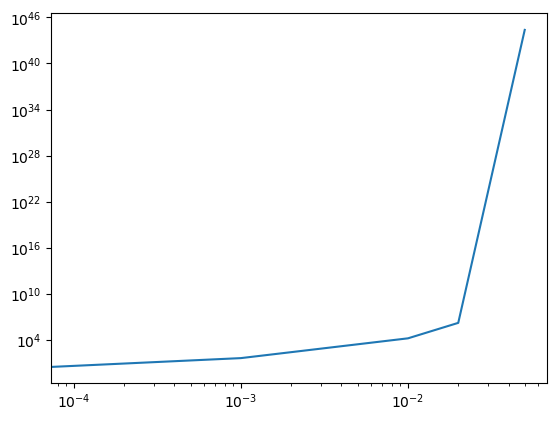

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x1c4a6a3e0>

In [52]:
loglog([0, 0.0001, 0.001, 0.01, 0.02, 0.05],[C0, C00, C01, C02, C03, C04])

## Section3
Set $\epsilon$ equals to 0.05, find out the first $k$ such that $p_k, d_k, \|x_k-x^*\|^2 \leq \epsilon$ under different choices of $(\lambda_k, \bar\beta)$.

In [62]:
function stopping_criteria_pt(f, gradf, xtrue, mu, dim, beta,eps,p)

    x1 = zeros(dim)
    basicQuadratic = Quadratic(0.0,x1,1.0)
    xi = x1
    x_average = xi    #equals \sum_i sigma_i x_i
    f_average = f(x1) #equals \sum_i sigma_i f(x_i)
    modeli = Quadratic(f(x1)-norm(gradf(x1),2)^2/(2*mu), x1 - gradf(x1)/mu, mu) #equals \sum_i theta_i quadratic_i
 
    sum_of_lambda_i = 1 #i^p
    
    i=1
    while f_average>eps
        i+=1
        #Compute penalized quadratic and update to next iterate
        penalizedQuadratic = addWeightedQuadratics(1.0, modeli, beta/sum_of_lambda_i, basicQuadratic)
        xi = penalizedQuadratic.minimizer

        #Compute new function values and gradients (at the newly computed next x_i) and update the model        
        fi = f(xi)
        gi = gradf(xi)
        eta = i^p/(sum_of_lambda_i + i^p)
        modeli = addWeightedQuadratics(1.0 - eta, modeli, eta, Quadratic(fi - norm(gi,2)^2/(2*mu), xi-gi/mu, mu))
        x_average = (1.0-eta)*x_average + eta*xi
        f_average = (1.0-eta)*f_average + eta*f(xi)

        sum_of_lambda_i += i^p
        
    end
    return i
end

stopping_criteria_pt (generic function with 1 method)

In [63]:
function stopping_criteria_pt_bar(f, gradf, xtrue, mu, dim, beta,eps,p)

    x1 = zeros(dim)
    basicQuadratic = Quadratic(0.0,x1,1.0)
    xi = x1
    x_average = xi    #equals \sum_i sigma_i x_i
    f_average = f(x1) #equals \sum_i sigma_i f(x_i)
    modeli = Quadratic(f(x1)-norm(gradf(x1),2)^2/(2*mu), x1 - gradf(x1)/mu, mu) #equals \sum_i theta_i quadratic_i
 
    sum_of_lambda_i = 1 #i^p
    
    i=1
    while f(x_average)>eps
        i+=1
        #Compute penalized quadratic and update to next iterate
        penalizedQuadratic = addWeightedQuadratics(1.0, modeli, beta/sum_of_lambda_i, basicQuadratic)
        xi = penalizedQuadratic.minimizer

        #Compute new function values and gradients (at the newly computed next x_i) and update the model        
        fi = f(xi)
        gi = gradf(xi)
        eta = i^p/(sum_of_lambda_i + i^p)
        modeli = addWeightedQuadratics(1.0 - eta, modeli, eta, Quadratic(fi - norm(gi,2)^2/(2*mu), xi-gi/mu, mu))
        x_average = (1.0-eta)*x_average + eta*xi
        f_average = (1.0-eta)*f_average + eta*f(xi)

        sum_of_lambda_i += i^p
        
    end
    return i
end

stopping_criteria_pt_bar (generic function with 1 method)

In [64]:
function stopping_criteria_deltat(f, gradf, xtrue, mu, dim, beta,eps,p)

    x1 = zeros(dim)
    basicQuadratic = Quadratic(0.0,x1,1.0)
    xi = x1
    x_average = xi    #equals \sum_i sigma_i x_i
    f_average = f(x1) #equals \sum_i sigma_i f(x_i)
    modeli = Quadratic(f(x1)-norm(gradf(x1),2)^2/(2*mu), x1 - gradf(x1)/mu, mu) #equals \sum_i theta_i quadratic_i
 
    sum_of_lambda_i = 1 #i^p
   
    i=1
    while f(xi)>eps
        i+=1
        #Compute penalized quadratic and update to next iterate
        penalizedQuadratic = addWeightedQuadratics(1.0, modeli, beta/sum_of_lambda_i, basicQuadratic)
        xi = penalizedQuadratic.minimizer

        #Compute new function values and gradients (at the newly computed next x_i) and update the model        
        fi = f(xi)
        gi = gradf(xi)
        eta = i^p/(sum_of_lambda_i + i^p)
        modeli = addWeightedQuadratics(1.0 - eta, modeli, eta, Quadratic(fi - norm(gi,2)^2/(2*mu), xi-gi/mu, mu))
        x_average = (1.0-eta)*x_average + eta*xi
        f_average = (1.0-eta)*f_average + eta*f(xi)

        sum_of_lambda_i += i^p

    end
    return i
end

stopping_criteria_deltat (generic function with 1 method)

In [65]:
function stopping_criteria_dt(f, gradf, xtrue, mu, dim, beta,eps,p)

    #We initialize at the origin for ease (start counting from i from 1 to avoid division by zero)    
    x1 = zeros(dim)
    basicQuadratic = Quadratic(0.0,x1,1.0)
    xi = x1
    x_average = xi    #equals \sum_i sigma_i x_i
    f_average = f(x1) #equals \sum_i sigma_i f(x_i)
    modeli = Quadratic(f(x1)-norm(gradf(x1),2)^2/(2*mu), x1 - gradf(x1)/mu, mu) #equals \sum_i theta_i quadratic_i
 
    sum_of_lambda_i = 1 #i^p
   
    i=1
    while -modeli.minimum>=eps
        i+=1
        #Compute penalized quadratic and update to next iterate
        penalizedQuadratic = addWeightedQuadratics(1.0, modeli, beta/sum_of_lambda_i, basicQuadratic)
        xi = penalizedQuadratic.minimizer

        #Compute new function values and gradients (at the newly computed next x_i) and update the model        
        fi = f(xi)
        gi = gradf(xi)
        eta = i^p/(sum_of_lambda_i + i^p)
        modeli = addWeightedQuadratics(1.0 - eta, modeli, eta, Quadratic(fi - norm(gi,2)^2/(2*mu), xi-gi/mu, mu))
        x_average = (1.0-eta)*x_average + eta*xi
        f_average = (1.0-eta)*f_average + eta*f(xi)

        sum_of_lambda_i += i^p 
        
    end
    return i
end

stopping_criteria_dt (generic function with 1 method)

In [66]:
function stopping_criteria_pt_dt(f, gradf, xtrue, mu, dim, beta,eps,p)

    #We initialize at the origin for ease (start counting from i from 1 to avoid division by zero)    
    x1 = zeros(dim)
    basicQuadratic = Quadratic(0.0,x1,1.0)
    xi = x1
    x_average = xi    #equals \sum_i sigma_i x_i
    f_average = f(x1) #equals \sum_i sigma_i f(x_i)
    modeli = Quadratic(f(x1)-norm(gradf(x1),2)^2/(2*mu), x1 - gradf(x1)/mu, mu) #equals \sum_i theta_i quadratic_i
 
    sum_of_lambda_i = 1 #i^p
  
    i=1
    while f_average-modeli.minimum>=eps
        i+=1
        #Compute penalized quadratic and update to next iterate
        penalizedQuadratic = addWeightedQuadratics(1.0, modeli, beta/sum_of_lambda_i, basicQuadratic)
        xi = penalizedQuadratic.minimizer

        #Compute new function values and gradients (at the newly computed next x_i) and update the model        
        fi = f(xi)
        gi = gradf(xi)
        eta = i^p/(sum_of_lambda_i + i^p)
        modeli = addWeightedQuadratics(1.0 - eta, modeli, eta, Quadratic(fi - norm(gi,2)^2/(2*mu), xi-gi/mu, mu))
        x_average = (1.0-eta)*x_average + eta*xi
        f_average = (1.0-eta)*f_average + eta*f(xi)

        sum_of_lambda_i += i^p
            
    end
    return i
end

stopping_criteria_pt_dt (generic function with 1 method)

In [67]:
function stopping_criteria_pt_bar_dt(f, gradf, xtrue, mu, dim, beta,eps,p)

    #We initialize at the origin for ease (start counting from i from 1 to avoid division by zero)    
    x1 = zeros(dim)
    basicQuadratic = Quadratic(0.0,x1,1.0)
    xi = x1
    x_average = xi    #equals \sum_i sigma_i x_i
    f_average = f(x1) #equals \sum_i sigma_i f(x_i)
    modeli = Quadratic(f(x1)-norm(gradf(x1),2)^2/(2*mu), x1 - gradf(x1)/mu, mu) #equals \sum_i theta_i quadratic_i
 
    sum_of_lambda_i = 1 #i^p
   
    i=1
    while f(x_average)-modeli.minimum>=eps
        i+=1
        #Compute penalized quadratic and update to next iterate
        penalizedQuadratic = addWeightedQuadratics(1.0, modeli, beta/sum_of_lambda_i, basicQuadratic)
        xi = penalizedQuadratic.minimizer

        #Compute new function values and gradients (at the newly computed next x_i) and update the model        
        fi = f(xi)
        gi = gradf(xi)
        eta = i^p/(sum_of_lambda_i + i^p)
        modeli = addWeightedQuadratics(1.0 - eta, modeli, eta, Quadratic(fi - norm(gi,2)^2/(2*mu), xi-gi/mu, mu))
        x_average = (1.0-eta)*x_average + eta*xi
        f_average = (1.0-eta)*f_average + eta*f(xi)

        sum_of_lambda_i += i^p
          
    end
    return i
end

stopping_criteria_pt_bar_dt (generic function with 1 method)

In [68]:
function stopping_criteria_deltat_dt(f, gradf, xtrue, mu, dim, beta,eps,p)

    #We initialize at the origin for ease (start counting from i from 1 to avoid division by zero)    
    x1 = zeros(dim)
    basicQuadratic = Quadratic(0.0,x1,1.0)
    xi = x1
    x_average = xi    #equals \sum_i sigma_i x_i
    f_average = f(x1) #equals \sum_i sigma_i f(x_i)
    modeli = Quadratic(f(x1)-norm(gradf(x1),2)^2/(2*mu), x1 - gradf(x1)/mu, mu) #equals \sum_i theta_i quadratic_i
 
    sum_of_lambda_i = 1 #i^p
 
    i=1
    while f(xi)-modeli.minimum>=eps
        i+=1
        #Compute penalized quadratic and update to next iterate
        penalizedQuadratic = addWeightedQuadratics(1.0, modeli, beta/sum_of_lambda_i, basicQuadratic)
        xi = penalizedQuadratic.minimizer

        #Compute new function values and gradients (at the newly computed next x_i) and update the model        
        fi = f(xi)
        gi = gradf(xi)
        eta = i^p/(sum_of_lambda_i + i^p)
        modeli = addWeightedQuadratics(1.0 - eta, modeli, eta, Quadratic(fi - norm(gi,2)^2/(2*mu), xi-gi/mu, mu))
        x_average = (1.0-eta)*x_average + eta*xi
        f_average = (1.0-eta)*f_average + eta*f(xi)

        sum_of_lambda_i += i^p
          
    end
    return i
end

stopping_criteria_deltat_dt (generic function with 1 method)

In [69]:
sigma=0

A1_sigma = A1(xtrue,n,m)
A2_sigma = A2(xtrue,n,m,sigma)
b1_sigma = A1_sigma*xtrue
b2_sigma = A2_sigma*xtrue
obj_sigma = x -> norm(A1_sigma*x-b1_sigma,p1)^p1 + norm(A2_sigma*x-b2_sigma,p2)^p2
objGrad_sigma = x -> ForwardDiff.gradient(obj_sigma, x)
mu_sigma = eigmin(A2_sigma'*A2_sigma)
eps=0.05

0.05

In [70]:
#beta=0,p=1
pt_bar=stopping_criteria_pt_bar(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,1)
pt=stopping_criteria_pt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,1)
deltat=stopping_criteria_deltat(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,1)
dt=stopping_criteria_dt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,1)
gap_pt_bar_dt=stopping_criteria_pt_bar_dt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,1)
gap_pt_dt=stopping_criteria_pt_dt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,1)
gap_deltat_dt=stopping_criteria_deltat_dt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,1)
(dt,pt_bar,gap_pt_bar_dt,deltat,gap_deltat_dt,pt,gap_pt_dt)

(2343, 743, 2463, 445925, 445943, 891882, 891891)

In [71]:
#beta=5,p=1
pt_bar=stopping_criteria_pt_bar(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 5,eps,1)
pt=stopping_criteria_pt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 5,eps,1)
deltat=stopping_criteria_deltat(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 5,eps,1)
dt=stopping_criteria_dt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 5,eps,1)
gap_pt_bar_dt=stopping_criteria_pt_bar_dt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 5,eps,1)
gap_pt_dt=stopping_criteria_pt_dt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 5,eps,1)
gap_deltat_dt=stopping_criteria_deltat_dt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 5,eps,1)
(dt,pt_bar,gap_pt_bar_dt,deltat,gap_deltat_dt,pt,gap_pt_dt)

(1789, 674, 1920, 460597, 460609, 921214, 921220)

In [72]:
#beta=50,p=1
pt_bar=stopping_criteria_pt_bar(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 50,eps,1)
pt=stopping_criteria_pt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 50,eps,1)
deltat=stopping_criteria_deltat(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 50,eps,1)
dt=stopping_criteria_dt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 50,eps,1)
gap_pt_bar_dt=stopping_criteria_pt_bar_dt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 50,eps,1)
gap_pt_dt=stopping_criteria_pt_dt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 50,eps,1)
gap_deltat_dt=stopping_criteria_deltat_dt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 50,eps,1)
(dt,pt_bar,gap_pt_bar_dt,deltat,gap_deltat_dt,pt,gap_pt_dt)

(1598, 895, 1851, 484280, 484291, 968567, 968573)

In [73]:
# mu =1, p = 2, beta = 0, eps = 0.05
pt_bar=stopping_criteria_pt_bar(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,2)
pt=stopping_criteria_pt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,2)
deltat=stopping_criteria_deltat(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,2)
dt=stopping_criteria_dt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,2)
gap_pt_bar_dt=stopping_criteria_pt_bar_dt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,2)
gap_pt_dt=stopping_criteria_pt_dt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,2)
gap_deltat_dt=stopping_criteria_deltat_dt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,2)
(dt,pt_bar,gap_pt_bar_dt,deltat,gap_deltat_dt,pt,gap_pt_dt)

(1411, 988, 1720, 649859, 649862, 974790, 974792)

In [74]:
# mu =1, p = 3, beta = 0, eps = 0.05
pt_bar=stopping_criteria_pt_bar(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,3.0)
pt=stopping_criteria_pt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,3.0)
deltat=stopping_criteria_deltat(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,3.0)
dt=stopping_criteria_dt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,3.0)
gap_pt_bar_dt=stopping_criteria_pt_bar_dt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,3.0)
gap_pt_dt=stopping_criteria_pt_dt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,3.0)
gap_deltat_dt=stopping_criteria_deltat_dt(obj_sigma, objGrad_sigma, xtrue, mu_sigma, n, 0,eps,3.0)
(dt,pt_bar,gap_pt_bar_dt,deltat,gap_deltat_dt,pt,gap_pt_dt)

(1616, 1318, 2084, 866478, 866481, 1155305, 1155307)

### comment:
In our experiment, some notations are different with what we use in our Numerical Experience and Validation section. I will clarify them now: $M_0$ we used here is the same as $L_0$ in our paper, $M_1$ is the same as $L_1$, $A_1$ is the same as $A$, $A_2$ is the same as $C$, $b_1$ is the same as $b$ and $b_2$ is the same as $d$.